## Домашнее здание №3 / New Product Forecasting

### Ческидова / 397

----
План выполнения домашнего задания:

1. Подготовка данных
2. Предсказание без категориальных признаков
3. Предсказание с категориальными признаками
4.  Другие модели и генерация дополнительных признаков
5. Отправка результатов в контест на Kaggle

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn import tree
from copy import deepcopy
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation
from sklearn.dummy import DummyRegressor
from scipy.optimize import minimize_scalar
%matplotlib inline

/home/fogside/virtualenv/python3/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Подготовка данных (1 балл)
 * Изучить признаки
 * Выделить категориальные признаки, которые можно использовать для обучения
 * Выделить датасет только с числовыми признаками
 * Выделить полезные числовые признаки

In [2]:
# data = pd.read_csv('blogData_train.csv', header=None)
data = pd.read_csv('./data/train.csv', sep=';', index_col='ID')
data.shape

(40000, 33)

In [381]:
# Посмотрим на данные
data.head(3)

,DEMAND,LOCATION_ID,MODEL_BRAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_DIAG_TYPE,MODEL_HEIGHT,MODEL_ID,MODEL_MEAN_SALES,...,STORE_FORMAT,STORE_OPEN_DTTM,STORE_PRICE_TYPE,STORE_REGION,STORE_RES_ABC,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,,,,,,,
0,0.10536,1835543262,ark,5179.75,NaN,5.5,big,720.0,1682,NaN,...,новый формат,19MAY15:00:00:00,розничная цена (северо-запад-санкт-петербург),северо-запад,B,0.67,0.75,0.25,0.0,3.06
1,0.00010,1972241965,samsung,22015.33,NaN,5.2,big,1920.0,34706,NaN,...,новый формат,20JAN16:00:00:00,розничная цена (северо-запад-днс1),северо-запад,C,0.48,0.00,1.00,0.0,2.51
2,0.00010,2027986985,samsung,15592.59,NaN,5.0,big,1280.0,2753,NaN,...,новый формат,27APR16:00:00:00,розничная цена (дальний восток-якутск),дальний восток,A,0.64,1.00,0.00,0.0,2.72


### Категориальные признаки
 * Какие категориальные признаки следует использовать в первую очередь? 
 * Есть ли категориальные признаки, которые в принципе не понятно, как использовать?

In [220]:
# Определяем категориальные признаки
# По понятным причинам 'LOCATION_ID', 'MODEL_ID' считаются числовыми признаками - их добавляем руками отдельно
Categorical_columns = data.columns[([isinstance(z, str) for z in data.ix[0]])] | data.columns[[1,8]]
print(len(Categorical_columns))
Categorical_columns

18


Index(['LOCATION_ID', 'MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_ID',
       'MODEL_NAME', 'MODEL_OS', 'MODEL_RES_TYPE', 'MODEL_TYPE',
       'STORE_BRAND_ABC', 'STORE_BUILDING_TYPE', 'STORE_CITY', 'STORE_CLUSTER',
       'STORE_DIAG_ABC', 'STORE_FORMAT', 'STORE_OPEN_DTTM', 'STORE_PRICE_TYPE',
       'STORE_REGION', 'STORE_RES_ABC'],
      dtype='object')

In [217]:
# Количество уникальных значений в категориальных признаках
dist_val = pd.DataFrame({'UniqueValues': [data[z].nunique() for z in Categorical_columns]}, index = Categorical_columns)

print('Количество уникальных категориальных значений: '+ str(dist_val.sum().values))
print('Удаляем признаки с номерами: \n'+ str(dist_val.ix[dist_val['UniqueValues']>0].sort_values(by='UniqueValues', ascending=False)))

Количество уникальных категориальных значений: [1654]
Удаляем признаки с номерами: 
                     UniqueValues
MODEL_ID                      447
MODEL_NAME                    447
LOCATION_ID                   362
STORE_OPEN_DTTM               246
STORE_CITY                     36
MODEL_BRAND                    33
STORE_CLUSTER                  23
STORE_PRICE_TYPE               20
STORE_FORMAT                   10
STORE_REGION                    5
MODEL_OS                        5
STORE_DIAG_ABC                  3
STORE_BUILDING_TYPE             3
STORE_BRAND_ABC                 3
MODEL_RES_TYPE                  3
MODEL_DIAG_TYPE                 3
STORE_RES_ABC                   3
MODEL_TYPE                      2


In [301]:
# Запоминаем те категориальные признаки, с которыми не будем далее работать (используется далее)
# Categorical_columns_use = Cathegorical_columns[]
Categorical_columns_use = ["STORE_CITY","STORE_FORMAT",
                           "STORE_PRICE_TYPE",
                           "MODEL_BRAND", "MODEL_OS",
                           "MODEL_TYPE"]

In [302]:
print(len(data.columns))
print(len(Categorical_columns_use))

33
6


### Числовые признаки
* Какие числовые признаки следует использовать в первую очередь? 
* Есть ли числовые признаки, которые в принципе не понятно, как использовать?
* Как заполнять NaN?

In [236]:
# Выделяем числовой датасет: В данном случае удаляем все + MODEL_ID и LOCATION_ID
num_data = data.drop(Categorical_columns | data.columns[[1,8]], axis = 1)
num_data.columns

Index(['DEMAND', 'MODEL_COST_AVG', 'MODEL_COUNT_SALES_DAYS', 'MODEL_DIAG',
       'MODEL_HEIGHT', 'MODEL_MEAN_SALES', 'MODEL_WIDTH', 'STORE_ASSORTMENT',
       'STORE_BRAND_SPECTR', 'STORE_DIAG_SPECTR', 'STORE_RES_SPECTR',
       'STORE_TYPE_A', 'STORE_TYPE_B', 'STORE_TYPE_C', 'STORE_TYPE_SPECTR'],
      dtype='object')

In [237]:
# Количество NaN в числовых признаках
print('Количество NaN:')
nan_val = num_data.isnull().sum().T
nan_val
# print('Удаляем признаки с номерами: \n'+ str(nan_val.sort_values(by='NoUniqueValues', ascending=False)))

Количество NaN:


DEMAND                        0
MODEL_COST_AVG                0
MODEL_COUNT_SALES_DAYS    18917
MODEL_DIAG                  212
MODEL_HEIGHT                212
MODEL_MEAN_SALES          18917
MODEL_WIDTH                 212
STORE_ASSORTMENT            235
STORE_BRAND_SPECTR          235
STORE_DIAG_SPECTR           442
STORE_RES_SPECTR            446
STORE_TYPE_A                  0
STORE_TYPE_B                  0
STORE_TYPE_C                  0
STORE_TYPE_SPECTR             0
dtype: int64

##### Преобразовываем числовые признаки (удаляем/добавляем/заменяем nan)

In [226]:
num_data.head()

,DEMAND,MODEL_COST_AVG,MODEL_COUNT_SALES_DAYS,MODEL_DIAG,MODEL_HEIGHT,MODEL_MEAN_SALES,MODEL_WIDTH,STORE_ASSORTMENT,STORE_BRAND_SPECTR,STORE_DIAG_SPECTR,STORE_RES_SPECTR,STORE_TYPE_A,STORE_TYPE_B,STORE_TYPE_C,STORE_TYPE_SPECTR
ID,,,,,,,,,,,,,,,
0,0.10536,5179.7500,NaN,5.5,720.0,NaN,1280.0,136.0,0.76,0.78,0.67,0.75,0.25,0.0,3.06
1,0.00010,22015.3300,NaN,5.2,1920.0,NaN,1080.0,70.0,0.73,0.65,0.48,0.00,1.00,0.0,2.51
2,0.00010,15592.5900,NaN,5.0,1280.0,NaN,1280.0,106.0,0.89,0.67,0.64,1.00,0.00,0.0,2.72
3,0.00010,540.9533,29.0,1.8,128.0,7.533,160.0,132.0,0.67,0.60,0.65,0.50,0.25,0.0,2.04
4,0.00010,444.7300,30.0,4.0,480.0,16.830,800.0,95.0,1.00,0.71,0.83,0.75,0.25,0.0,2.37


### Посмотрим на корреляцию признаков ###

In [238]:
corr_data = num_data.corr()
dict_corr = {}
for col in corr_data.columns:
    for col_inx in corr_data.index:
        if (col!=col_inx) and (corr_data.ix[col_inx, col]>=0.7):
            if ((col, col_inx) not in dict_corr.keys()) or ((col_inx, col) not in dict_corr.keys()):
                dict_corr[(col, col_inx)] = corr_data.ix[col_inx, col]

In [239]:
keys = list(dict_corr.keys())
keys.sort(key=lambda x: x[0])

for key in keys:
    print(key, dict_corr[key])

('MODEL_COST_AVG', 'MODEL_HEIGHT') 0.799631009737
('MODEL_DIAG', 'MODEL_WIDTH') 0.872693895322
('MODEL_HEIGHT', 'MODEL_COST_AVG') 0.799631009737
('MODEL_WIDTH', 'MODEL_DIAG') 0.872693895322
('STORE_ASSORTMENT', 'STORE_TYPE_SPECTR') 0.721544917841
('STORE_ASSORTMENT', 'STORE_TYPE_A') 0.733677237935
('STORE_BRAND_SPECTR', 'STORE_DIAG_SPECTR') 0.716302854632
('STORE_BRAND_SPECTR', 'STORE_TYPE_SPECTR') 0.722115061108
('STORE_DIAG_SPECTR', 'STORE_TYPE_SPECTR') 0.861491639257
('STORE_DIAG_SPECTR', 'STORE_RES_SPECTR') 0.848910479473
('STORE_DIAG_SPECTR', 'STORE_BRAND_SPECTR') 0.716302854632
('STORE_RES_SPECTR', 'STORE_TYPE_SPECTR') 0.82569252293
('STORE_RES_SPECTR', 'STORE_DIAG_SPECTR') 0.848910479473
('STORE_TYPE_A', 'STORE_ASSORTMENT') 0.733677237935
('STORE_TYPE_SPECTR', 'STORE_ASSORTMENT') 0.721544917841
('STORE_TYPE_SPECTR', 'STORE_BRAND_SPECTR') 0.722115061108
('STORE_TYPE_SPECTR', 'STORE_DIAG_SPECTR') 0.861491639257
('STORE_TYPE_SPECTR', 'STORE_RES_SPECTR') 0.82569252293


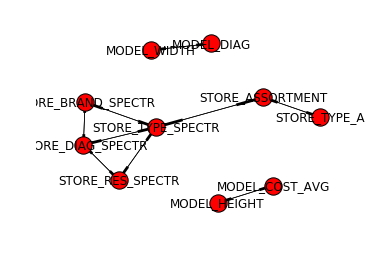

In [250]:
import networkx as nx

G = nx.DiGraph()
G.add_edges_from(keys)
plt.axis('off')
nx.draw_networkx(G, width=0.7)

Думаю, исходя из полученной картинки, можно оставить только один признак из 4х:
* "STORE_BRAND_SPECTR"
* "STORE_DIAG_SPECTR"
* "STORE_TYPE_SPECTR"
* "STORE_RES_SPECTR"

In [252]:
##Здесь добавьте код по заполнению NaN
## Просто заполнили пропуски в MODEL_MEAN_SALES средними значениями по модели с данной os
dict_diag_sales = data.groupby("MODEL_OS")["MODEL_MEAN_SALES"].mean().to_dict()
dict_to_fill = {i:dict_diag_sales[data.ix[i,"MODEL_OS"]] for i in range(len(num_data))}
num_data["MODEL_MEAN_SALES"].fillna(dict_to_fill, inplace=True)
num_data.fillna(0, inplace=True)

In [253]:
# Здесь добавьте код по удалению числовых признаков
num_data.drop(["MODEL_COUNT_SALES_DAYS", "MODEL_WIDTH", "STORE_RES_SPECTR", "STORE_TYPE_SPECTR", "STORE_DIAG_SPECTR"], axis = 1, inplace=True)
num_data.columns

Index(['DEMAND', 'MODEL_COST_AVG', 'MODEL_DIAG', 'MODEL_HEIGHT',
       'MODEL_MEAN_SALES', 'STORE_ASSORTMENT', 'STORE_BRAND_SPECTR',
       'STORE_TYPE_A', 'STORE_TYPE_B', 'STORE_TYPE_C'],
      dtype='object')

## Предсказание без категориальных признаков (1 балл)
### Вспомогательные функции

In [28]:
def smape_loss_func(x, y):
    SymAPE = [ 2*np.abs(x-y)/(np.abs(x)+np.abs(y))] 
    return np.mean(SymAPE)

def get_numerated_data(df, categorical_columns):
    simple_df = deepcopy(df)
    for column in categorical_columns:
        simple_df[column] = pd.Categorical.from_array(simple_df[column]).labels
    
    return simple_df

def get_binarized_data(df, categorical_columns):
    binary_df = deepcopy(df)
    for column in categorical_columns:
        binary_df = pd.concat([binary_df, pd.get_dummies(binary_df[column], prefix=column, prefix_sep=': ')], axis=1)
        del binary_df[column]
    
    return binary_df

def split_to_numpy(df, y_column_name):
    #print df
    #print y_column_name
    data_x = df.drop(y_column_name, axis=1).values.astype(np.float32)
    data_y = df[y_column_name].values.astype(np.float32)
    column_names = df.drop(y_column_name, axis=1).columns
    
    return data_x, data_y, column_names

def split_train_test(df, test_size=0.5, random_state=42, y_column_name='y'):
    X = np.asarray(df.drop(y_column_name, axis=1))
    y = np.asarray(df[y_column_name]).ravel()
    trainX, testX, trainY, testY = cross_validation.train_test_split(X, y, test_size=test_size, random_state=42)
    return trainX, testX, trainY, testY

### Необходимые функции

In [109]:
def show_plot(n_est, res, title="", ylabel="acc"):
    fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][1] for x in n_est], 'ro', label="test")
#     ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
#     plt.xlabel("n_estimators")
#     plt.ylabel(ylabel)
#     plt.title("Test result")
#     plt.show()
    
#     fig, ax = plt.subplots()
    ax.plot(n_est, [res[x][0] for x in n_est], 'bo', label='train')
    ax.set_xlim((np.min(n_est) - 10, np.max(n_est) + 10))
    plt.xlabel("n_estimators")
    plt.ylabel("acc")
    plt.legend()
    plt.title(title)
    plt.show()

def get_results_dummy_reg(acc=smape_loss_func, verbose=True, strg ='mean', const=None):
    results = dict()
    reg = DummyRegressor(strategy=strg, constant=const)
    reg.fit(trainX, trainY)
    predict = reg.predict(testX)
    results[1] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
    if verbose:
        print("Accuracy: " + str(results[1][1]))
    return results

def get_results_baggind_rsm(n_est, max_samples, max_features, acc=smape_loss_func, verbose=True):
    results = dict()
    for i in n_est:
        reg = BaggingRegressor(n_estimators=i,
                          max_samples=max_samples, max_features=max_features, random_state=1234, n_jobs=-1, verbose=0)
        reg.fit(trainX, trainY)
#         results[i] = (mse(reg.predict(trainX), trainY), mse(reg.predict(testX), testY))
        predict = reg.predict(testX)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_rf(n_est, oob=False, verbose=True, acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = RandomForestRegressor(n_estimators=i, n_jobs=-1, random_state=1234, verbose=0,
                                    oob_score=oob, max_features='sqrt')
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if oob:
            results[i] = (reg.oob_score_, acc(predict, testY))
        else:
            results[i] = (acc(trainY, reg.predict(trainX)), acc(testY,predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_erte(n_est, verbose=True,acc=smape_loss_func):
    results = dict()
    for i in n_est:
        reg = ExtraTreesRegressor(n_estimators=i, n_jobs=-1, random_state=12, verbose=0)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        results[i] = (acc(trainY,reg.predict(trainX)), acc(predict, testY))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))
    return results

def get_results_gbdt(n_est, verbose=True, init=None, acc=smape_loss_func, min_max_filter=True, max_val=1, min_val=0.001):
    results = dict()
    for i in n_est:
        if init is not None:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0, init=init)
        else:
            reg = GradientBoostingRegressor(n_estimators=i, random_state=1234, verbose=0, max_features='sqrt', max_depth=7)
        reg.fit(trainX, trainY)
        predict = reg.predict(testX)
        if min_max_filter:
            predict = np.minimum(np.maximum(predict, min_val),max_val)
        results[i] = (acc(trainY, reg.predict(trainX)), acc(testY, predict))
        if verbose:
            print("Count of estimators: " + str(i) + ", accuracy: " + str(results[i][1]))    
    return results

def get_optimal(results):
    results = sorted(results, key=lambda x: x[1])

### Делим выборку на обучение и контроль

In [255]:
trainX, testX, trainY, testY = split_train_test(df = num_data, test_size=0.1,  y_column_name='DEMAND')

### DummyRegressor
* Самый простой классификатор на числовых признаках используется как база для сравнения

In [31]:
%time results = get_results_dummy_reg()
%time results = get_results_dummy_reg(strg='constant', const=0.001)

Accuracy: 1.24306344718
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.1 ms
Accuracy: 1.81014628129
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.6 ms


### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

** Каким стоит брать размер bootstrap выборки и RSM выборки ** 
Например: 
**Bagging:** 0.5 от размера тестовой выборки.

**RSM:** 0.5 от размера тестовой выборки.

Count of estimators: 10, accuracy: 1.21584760434
Count of estimators: 20, accuracy: 1.20950667664
Count of estimators: 30, accuracy: 1.20509976886
Count of estimators: 40, accuracy: 1.20436161617
Count of estimators: 50, accuracy: 1.20304558414
Count of estimators: 60, accuracy: 1.20555931569
Count of estimators: 70, accuracy: 1.20557324154
Count of estimators: 80, accuracy: 1.20780229184
Count of estimators: 90, accuracy: 1.21089811323
Count of estimators: 100, accuracy: 1.21139269082
Count of estimators: 110, accuracy: 1.2110078017
Count of estimators: 120, accuracy: 1.2114779749
Count of estimators: 130, accuracy: 1.2103592099
Count of estimators: 140, accuracy: 1.21087669876
CPU times: user 9.83 s, sys: 4.92 s, total: 14.7 s
Wall time: 38.8 s


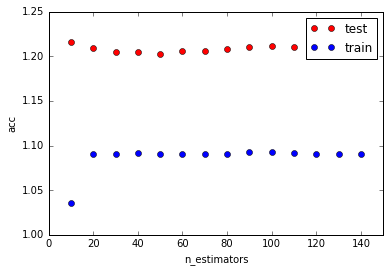

In [256]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.6, 0.7, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.18083827234
Count of estimators: 20, accuracy: 1.20763649993
Count of estimators: 30, accuracy: 1.21357295144
Count of estimators: 40, accuracy: 1.21519587862
Count of estimators: 50, accuracy: 1.21577903344
Count of estimators: 60, accuracy: 1.21654211532
Count of estimators: 70, accuracy: 1.21531870095
Count of estimators: 80, accuracy: 1.21587231903
Count of estimators: 90, accuracy: 1.21700443733
Count of estimators: 100, accuracy: 1.21649147789
Count of estimators: 110, accuracy: 1.21537538198
Count of estimators: 120, accuracy: 1.21547317556
Count of estimators: 130, accuracy: 1.21518245831
Count of estimators: 140, accuracy: 1.21526132225
CPU times: user 1min 23s, sys: 520 ms, total: 1min 23s
Wall time: 21.3 s


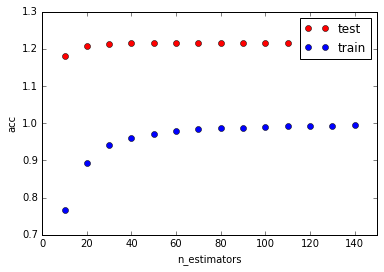

In [257]:
n_est = range(10, 150, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.14746549864
Count of estimators: 20, accuracy: 1.19596577959
Count of estimators: 30, accuracy: 1.2078649394
Count of estimators: 40, accuracy: 1.21507105837
Count of estimators: 50, accuracy: 1.21743075474
Count of estimators: 60, accuracy: 1.22099028812
Count of estimators: 70, accuracy: 1.22214345924
Count of estimators: 80, accuracy: 1.22473658052
Count of estimators: 90, accuracy: 1.22423399085
Count of estimators: 100, accuracy: 1.22490554213
Count of estimators: 110, accuracy: 1.22590513976
Count of estimators: 120, accuracy: 1.22582881334
Count of estimators: 130, accuracy: 1.22709694424
Count of estimators: 140, accuracy: 1.22674269652
CPU times: user 1min 47s, sys: 748 ms, total: 1min 48s
Wall time: 26.2 s


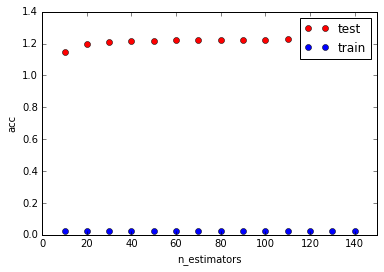

In [258]:
n_est = range(10, 150, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

## Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.22524718494
Count of estimators: 20, accuracy: 1.21838848497
Count of estimators: 30, accuracy: 1.21670201767
Count of estimators: 40, accuracy: 1.21974986252
Count of estimators: 50, accuracy: 1.2213069109
Count of estimators: 60, accuracy: 1.22157354021
Count of estimators: 70, accuracy: 1.22436795557
Count of estimators: 80, accuracy: 1.22382024223
Count of estimators: 90, accuracy: 1.2255952456
Count of estimators: 100, accuracy: 1.22762575981
Count of estimators: 110, accuracy: 1.22790635371
Count of estimators: 120, accuracy: 1.22827834746
Count of estimators: 130, accuracy: 1.22921308356
Count of estimators: 140, accuracy: 1.23044784701
CPU times: user 23.7 s, sys: 0 ns, total: 23.7 s
Wall time: 23.7 s


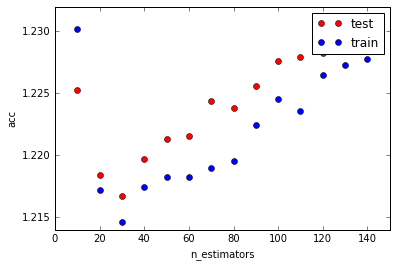

In [259]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод
Переобучаются ExtraDT, остальные методы показывают результаты на одном уровне (в пределах погрешности).

Для RF и Baggin+RSM оптимальные значения кол-ва близко к 20.

Для GBDT оптимальное количество алгоритмов находится в районе 50.

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

Bagging и Boosting дают примерно одинаковые результаты, если количество деревьев в бустинге брать равным 30-40.

Того же уровня результаты получаются при использовании RF и ExtraDT, только последний сильно переобучается при большом числе деревьев.

## Использование категориальных признаков (1 балл)
* Проведите аналогичный экспермент при наличии категориальных признаков

### Обучение и Контроль

In [704]:
Categorical_columns

Index(['LOCATION_ID', 'MODEL_BRAND', 'MODEL_DIAG_TYPE', 'MODEL_ID',
       'MODEL_NAME', 'MODEL_OS', 'MODEL_RES_TYPE', 'MODEL_TYPE',
       'STORE_BRAND_ABC', 'STORE_BUILDING_TYPE', 'STORE_CITY', 'STORE_CLUSTER',
       'STORE_DIAG_ABC', 'STORE_FORMAT', 'STORE_OPEN_DTTM', 'STORE_PRICE_TYPE',
       'STORE_REGION', 'STORE_RES_ABC'],
      dtype='object')

In [705]:
Categorical_columns_use = ['MODEL_OS','MODEL_BRAND']

In [706]:
# Для обучения используются полезные категориальные признаки
bin_data = get_binarized_data(data, Categorical_columns_use)
print(bin_data.shape)

(40000, 69)


##### Исключаем лишние произнаки, заменяем NaN

In [707]:
# Удаляем лишние категоримальные признаки
# bin_data.drop(Categorical_columns[лишние категориальные признаки], axis = 1, inplace=True)
bin_data.drop(list(set(Categorical_columns_use) ^ set(Categorical_columns)), axis = 1, inplace=True)

In [708]:
# Удаляем лишние числвые признаки признаки
# to_drop = ["MODEL_COUNT_SALES_DAYS", "MODEL_WIDTH", "STORE_RES_SPECTR", "STORE_TYPE_SPECTR", "STORE_DIAG_SPECTR"]
to_drop = ["MODEL_WIDTH", "MODEL_HEIGHT"]
to_use = list(set(data.columns ^ Categorical_columns)^set(to_drop)^set(["DEMAND"]))
bin_data.drop(to_drop, axis = 1, inplace = True)

# Заменяем NaN
for num_col in to_use:
    dict_diag_sales = data.groupby("MODEL_BRAND")[num_col].mean().to_dict()
    dict_to_fill = {i:dict_diag_sales[data.ix[i,"MODEL_BRAND"]] for i in range(len(data))}
    bin_data[num_col].fillna(dict_to_fill, inplace=True)    
# bin_data.fillna(0, inplace=True)

nan_val = bin_data[to_use].isnull().sum().T
nan_val

MODEL_DIAG                0
STORE_DIAG_SPECTR         0
MODEL_COST_AVG            0
MODEL_COUNT_SALES_DAYS    0
STORE_RES_SPECTR          0
STORE_ASSORTMENT          0
STORE_TYPE_A              0
STORE_BRAND_SPECTR        0
STORE_TYPE_SPECTR         0
STORE_TYPE_C              0
MODEL_MEAN_SALES          0
STORE_TYPE_B              0
dtype: int64

In [709]:
# Делим выборку на обучение и контроль
trainX, testX, trainY, testY = split_train_test(df = bin_data, test_size=0.1,  y_column_name='DEMAND')

### FEATURE IMPORTANCE ####

In [546]:
import operator
import xgboost as xgb
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, ''.join(feat.split(' '))))
        i = i + 1

    outfile.close()

ceate_feature_map(bin_data.columns[1:])

xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1}
num_rounds = 200

dtrain = xgb.DMatrix(trainX, label=trainY)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

importance = gbdt.get_fscore(fmap='xgb.fmap')
# importance = gbdt.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

# plt.figure()
# df.plot()
# df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
# plt.title('XGBoost Feature Importance')
# plt.xlabel('relative importance')

In [547]:
most_important = df.sort('fscore', ascending=False)['feature'][:30]

/home/fogside/virtualenv/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [548]:
most_important

39                         knn
38          STORE_BRAND_SPECTR
37           STORE_TYPE_SPECTR
36              MODEL_COST_AVG
35            STORE_ASSORTMENT
34      MODEL_COUNT_SALES_DAYS
33            STORE_RES_SPECTR
32           STORE_DIAG_SPECTR
31            MODEL_MEAN_SALES
30                  MODEL_DIAG
29                STORE_TYPE_B
28                STORE_TYPE_A
27             MODEL_BRAND:htc
26            MODEL_BRAND:asus
25           MODEL_BRAND:haier
24       MODEL_BRAND:microsoft
23        MODEL_BRAND:micromax
21            MODEL_BRAND:sony
22             MODEL_BRAND:zte
20          MODEL_BRAND:huawei
19           MODEL_BRAND:meizu
18             MODEL_OS:gsm-wm
17         MODEL_BRAND:samsung
16            MODEL_OS:gsm-and
15             MODEL_BRAND:мтс
14         MODEL_BRAND:philips
13          MODEL_BRAND:lexand
12    MODEL_BRAND:bright&quick
10            MODEL_OS:gsm-ios
11              MODEL_BRAND:lg
Name: feature, dtype: object

### Bagging and RSM
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.08107516358
Count of estimators: 20, accuracy: 1.11951884596
Count of estimators: 30, accuracy: 1.1471976867
Count of estimators: 40, accuracy: 1.17023848874
CPU times: user 3.44 s, sys: 2.7 s, total: 6.14 s
Wall time: 14.6 s


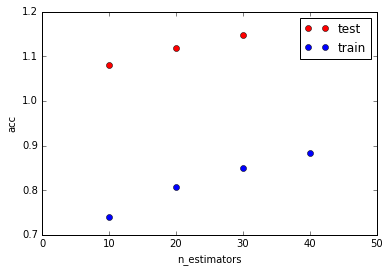

In [549]:
n_est = range(10, 50, 10)
%time results = get_results_baggind_rsm(n_est, 0.7, 0.8, verbose=True)
show_plot(n_est, results)

Count of estimators: 10, accuracy: 1.03862671151
Count of estimators: 20, accuracy: 1.05763524287
Count of estimators: 30, accuracy: 1.11820090827
Count of estimators: 40, accuracy: 1.1235553396
Count of estimators: 50, accuracy: 1.12217259884
Count of estimators: 60, accuracy: 1.1209137119
Count of estimators: 70, accuracy: 1.11955384413
Count of estimators: 80, accuracy: 1.12800878057
Count of estimators: 90, accuracy: 1.1471233891
Count of estimators: 100, accuracy: 1.16189096747
Count of estimators: 110, accuracy: 1.16041995668
Count of estimators: 120, accuracy: 1.16667668593
Count of estimators: 130, accuracy: 1.16516621416
Count of estimators: 140, accuracy: 1.17020926628
CPU times: user 19.2 s, sys: 12.2 s, total: 31.4 s
Wall time: 2min 9s


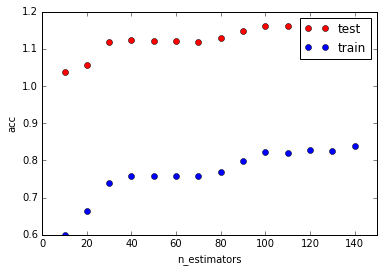

In [550]:
n_est = range(10, 150, 10)
%time results = get_results_baggind_rsm(n_est, 0.9, 0.9, verbose=True)
show_plot(n_est, results)

### Random Forest
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.10441850031
Count of estimators: 20, accuracy: 1.16294287917
Count of estimators: 30, accuracy: 1.17951416005
Count of estimators: 40, accuracy: 1.18669714505
Count of estimators: 50, accuracy: 1.18996508784
CPU times: user 13.8 s, sys: 68 ms, total: 13.9 s
Wall time: 4.39 s


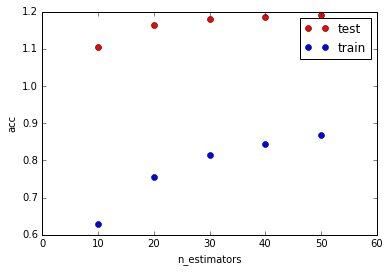

In [551]:
n_est = range(10, 60, 10)
%time results = get_results_rf(n_est)
show_plot(n_est, results)

### Extremely Randomized Trees Ensemble
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 0.99121401534
Count of estimators: 20, accuracy: 1.01235032725
Count of estimators: 30, accuracy: 1.01459720022
Count of estimators: 40, accuracy: 1.01662828106
Count of estimators: 50, accuracy: 1.01884761141
Count of estimators: 60, accuracy: 1.01910824924
CPU times: user 1min 5s, sys: 104 ms, total: 1min 5s
Wall time: 15.3 s


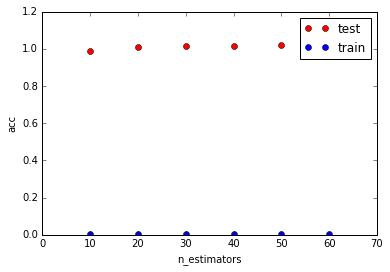

In [552]:
n_est = range(10, 70, 10)
%time results = get_results_erte(n_est)
show_plot(n_est, results)

### Gradient Boosted Decision Trees
Диапазон для n_est рекомендуется брать небольшим

Если трубется изменять дефолтные параметры алгоритма - меняйте код выше

Count of estimators: 10, accuracy: 1.18309134951
Count of estimators: 20, accuracy: 1.16273607924
Count of estimators: 30, accuracy: 1.17042793618
Count of estimators: 40, accuracy: 1.17987315233
Count of estimators: 50, accuracy: 1.1895156178
Count of estimators: 60, accuracy: 1.19337878824
Count of estimators: 70, accuracy: 1.19542377578
Count of estimators: 80, accuracy: 1.19824863198
Count of estimators: 90, accuracy: 1.19808227043
Count of estimators: 100, accuracy: 1.20080489954
Count of estimators: 110, accuracy: 1.19964807372
Count of estimators: 120, accuracy: 1.20309493813
Count of estimators: 130, accuracy: 1.20787180203
Count of estimators: 140, accuracy: 1.20826312348
CPU times: user 38.2 s, sys: 0 ns, total: 38.2 s
Wall time: 38.2 s


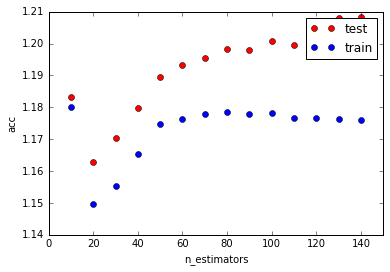

In [553]:
n_est = range(10, 150, 10)
%time results = get_results_gbdt(n_est)
show_plot(n_est, results)

### Вывод

**Вопрос: Дайте интепретацию полученным результатам в вашем случае.**

## Другие модели и генерация дополнительных признаков (2 балла)

* На основании сделанных выводов, предложите другой вариант алгоритма ML, который должен показать лучший результат
* Направляния:
    -- использовать принципиально другое семейство алгоритмов (NN, GB+kNN, LinearRegression, композиция Baggin и GBDT)
    -- исключить бесполезные фичи из обучающей выборки (полезность фич проанализировать с помощью RF);
    -- исключить фичи, в которых есть NaN; сделать восстановление NaN более интеллектуально;
    -- преобразовать катеориальные признаки так, чтобы получились числовые.

In [693]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
import xgboost as xgb

In [681]:
## LinearRegression ##

lr = LinearRegression()
lr.fit(trainX, trainY)
pred = lr.predict(testX)
smape_loss_func(pred, testY)

1.2780688284662152

In [ ]:
## XGB ##

In [484]:
%%time
from tqdm import tqdm
xgb_reg = xgb.XGBRegressor()
xgb_params = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100, 300, 400],
    'max_depth': [2, 3, 7],
}

results = {}
for lr in tqdm(xgb_params['learning_rate']):
    for n in xgb_params['n_estimators']:
        for d in xgb_params['max_depth']:
            xgb_reg = xgb.XGBRegressor(learning_rate=lr, n_estimators=n, max_depth=d)
            xgb_reg.fit(trainX, trainY)
            pred = xgb_reg.predict(testX)
            tmp = smape_loss_func(pred, testY)
            print("lr:{}, n:{}, d:{} -- {}".format(lr, n, d, tmp))
            results[(lr,n,d)] = tmp


  0%|          | 0/2 [00:00<?, ?it/s]

lr:0.05, n:50, d:2 -- 1.26650350560964



Exception in thread Thread-5183:
Traceback (most recent call last):
  File "/usr/lib/python3.4/threading.py", line 920, in _bootstrap_inner
    self.run()
  File "/home/fogside/virtualenv/python3/lib/python3.4/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/fogside/virtualenv/python3/lib/python3.4/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



lr:0.05, n:50, d:3 -- 1.2641565117031945
lr:0.05, n:50, d:7 -- 1.2474660207810786
lr:0.05, n:100, d:2 -- 1.221449431026167
lr:0.05, n:100, d:3 -- 1.2209253677712484
lr:0.05, n:100, d:7 -- 1.2076570215737779
lr:0.05, n:300, d:2 -- 1.2203006005602761
lr:0.05, n:300, d:3 -- 1.2349757862197384
lr:0.05, n:300, d:7 -- 1.2292013524498375
lr:0.05, n:400, d:2 -- 1.2247926380571987
lr:0.05, n:400, d:3 -- 1.2403253496598572


 50%|█████     | 1/2 [06:30<06:30, 390.21s/it]

lr:0.05, n:400, d:7 -- 1.229415682852496
lr:0.1, n:50, d:2 -- 1.221370004613539
lr:0.1, n:50, d:3 -- 1.2208603662384372
lr:0.1, n:50, d:7 -- 1.2107986231863628
lr:0.1, n:100, d:2 -- 1.2195357001983023
lr:0.1, n:100, d:3 -- 1.2247968088835577
lr:0.1, n:100, d:7 -- 1.2226603519169457
lr:0.1, n:300, d:2 -- 1.23708749420454
lr:0.1, n:300, d:3 -- 1.2405899563442218
lr:0.1, n:300, d:7 -- 1.249964318963809
lr:0.1, n:400, d:2 -- 1.241059224390899
lr:0.1, n:400, d:3 -- 1.2513233219444182


100%|██████████| 2/2 [13:05<00:00, 391.82s/it]

lr:0.1, n:400, d:7 -- 1.2575016533411054
CPU times: user 57min 39s, sys: 5.35 s, total: 57min 45s
Wall time: 13min 5s


In [516]:
## NN ##

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

bin_data2 = bin_data.copy()
bin_data2.drop("MODEL_COUNT_SALES_DAYS", axis=1)

trainX_1, testX_1, trainY_1, testY_1 = split_train_test(df = bin_data2, test_size=0.1,  y_column_name='DEMAND')

trainX_1 = scaler.fit_transform(trainX_1)
testX_1 = scaler.transform(testX_1)

nn = MLPRegressor(hidden_layer_sizes=[200,10], learning_rate='adaptive')
nn.fit(trainX_1, trainY_1)

smape_loss_func(nn.predict(testX_1), testY_1)

1.3666642341531936

Удивительно, но похоже, что KNN оказалась самой удачной моделью..

In [672]:
### KNN ###

# knn_res = []

for n in [2,3,4,5,6,7]:
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(trainX, trainY)
    pred = knn.predict(testX)
    tmp = smape_loss_func(pred, testY), smape_loss_func(knn.predict(trainX), trainY)
    print("n:{} test:{} train:{}".format(n, tmp[0], tmp[1]))
#     knn_res.append(tmp)

n:2 test:0.852288138074966 train:0.4707706248466773
n:3 test:0.9209695963381682 train:0.6581888558932417
n:4 test:0.9802826156017517 train:0.7785182108303719
n:5 test:1.0208646876639134 train:0.8657240385603392
n:6 test:1.0599687183167656 train:0.9293105327736723
n:7 test:1.0859612311702138 train:0.9770914159924212


In [673]:
metrics = ['euclidean', 'manhattan', "chebyshev", "minkowski"]
for m in metrics:
    knn = KNeighborsRegressor(n_neighbors=2, metric=m)
    knn.fit(trainX, trainY)
    pred = knn.predict(testX)
    tmp = smape_loss_func(pred, testY), smape_loss_func(knn.predict(trainX), trainY)
    print("m:{} test:{} train:{}".format(m, tmp[0], tmp[1]))

m:euclidean test:0.852288138074966 train:0.4707706248466773
m:manhattan test:0.8289360013289367 train:0.4624458434239351
m:chebyshev test:0.8647096052897755 train:0.4789299565325316
m:minkowski test:0.852288138074966 train:0.4707706248466773


In [674]:
def local_scorer(estimator, X, y):
    pred = estimator.predict(X)
    return smape_loss_func(pred, y)

In [675]:
knn = KNeighborsRegressor(n_neighbors=2, metric='manhattan')
simple_data = cross_val_score(knn, trainX, trainY, scoring=local_scorer)
print(simple_data)

[ 0.83572031  0.83608012  0.83498232]


О, боже. Но вот я попробовала AdaBoost, но было уже слишком поздно...
Очень грустно.

In [710]:
## ADA ##

tree = DecisionTreeRegressor()
ada = AdaBoostRegressor(base_estimator=tree)
ada.fit(trainX, trainY)
pred = ada.predict(testX)
smape_loss_func(pred, testY)

0.76518166682780209

In [711]:
cross_val_score(ada, trainX, trainY, scoring=local_scorer)

array([ 0.75204471,  0.73472304,  0.75382551])

In [702]:
## ADA_Knn ##

knn = KNeighborsRegressor(n_neighbors=2, metric='manhattan')
ada_knn = AdaBoostRegressor(base_estimator=knn)
ada_knn.fit(trainX, trainY)
pred = ada_knn.predict(testX)
smape_loss_func(pred, testY)

0.80336457364881197

In [723]:
cross_val_score(ada_knn, trainX, trainY, scoring=local_scorer)

array([ 0.88749106,  0.79813189,  0.81563325])

### Вывод

Надо было начинать с KNN.

В ноутбуке было бы совершенно неудобно отражать это, но KNN начал хорошо работать на определенном наборе фичей.

В целом, этот набор согласуется с тем, что выдал xgb feature_importance, так что это было сделано не зря.

Очень жаль, что я слишком поздно вспомнила про AdaBoost.

## Отправка результатов в контест на Kaggle (оценивается по результатам в Leaderboard)

In [714]:
test = pd.read_csv('./data/test.csv', sep=';',decimal= '.', index_col='ID')

In [715]:
# Предобработка тестовой выборки (добавляем\удаляем признаки, предобработка NaN и пр.)
test_data = get_binarized_data(test, Categorical_columns_use)

In [716]:
# Все отсутствующие в тестовой выборке столбцы полагаем 0
add_columns = bin_data.columns[1:].difference(test_data.columns)
test_data = pd.merge(test_data, bin_data.ix[test_data.index][add_columns], how='inner', left_index=True, right_index=True)
test_data[add_columns]=0

# Оставляем только столбцы обучающей выборки (целевая переменная в обучающей выборке отсутствует)
test_data = test_data.ix[:,bin_data.columns[1:]]


In [717]:
## Замена пропусков средним для данной колонки по бренду.

for num_col in to_use:
    dict_diag_sales = test.groupby("MODEL_BRAND")[num_col].mean().to_dict()
    dict_to_fill = {i:dict_diag_sales[test.ix[i,"MODEL_BRAND"]] for i in range(len(test))}
    test_data[num_col].fillna(dict_to_fill, inplace=True)    
test_data.fillna(0, inplace=True)

nan_val = test_data[to_use].isnull().sum().T
nan_val

MODEL_DIAG                0
STORE_DIAG_SPECTR         0
MODEL_COST_AVG            0
MODEL_COUNT_SALES_DAYS    0
STORE_RES_SPECTR          0
STORE_ASSORTMENT          0
STORE_TYPE_A              0
STORE_BRAND_SPECTR        0
STORE_TYPE_SPECTR         0
STORE_TYPE_C              0
MODEL_MEAN_SALES          0
STORE_TYPE_B              0
dtype: int64

In [718]:
# Обучающая выборка
trainX, _, trainY, _ = split_train_test(df = bin_data, test_size=0,  y_column_name='DEMAND')

In [645]:
# Это алгоритм из LeaderBoard
final_regressor = KNeighborsRegressor(n_neighbors=2, metric='manhattan')
final_regressor.fit(trainX, trainY)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='uniform')

In [719]:
# А это алгоритм получше, дающий 0.77 на PrivateLeaderboard, но надо было его вовремя сабмиттить.
tree = DecisionTreeRegressor()
final_regressor = AdaBoostRegressor(base_estimator=tree)
final_regressor.fit(trainX, trainY)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)

In [720]:
# Предсказание интенсивности
test_predict = final_regressor.predict(np.asarray(test_data))

In [721]:
# Сохраняем в csv-файл
test['DEMAND'] = test_predict
test[['DEMAND']].to_csv('./data/submission_ada.csv', sep = ',', index = True)